##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 4 - Google Search grounding with the Gemini API

Welcome back to the Kaggle 5-day Generative AI course!

In this optional notebook, you will use [Google Search](https://google.com/) results with the Gemini API in a technique called grounding, where the model is connected to verifiable sources of information. Using search grounding is similar to using the RAG system you implemented earlier in the week, but the Gemini API automates a lot of it for you. The model generates Google Search queries and invokes the searches automatically, retrieving relevant data from Google's index of the web and providing links to search suggestions that support the query, so your users can verify the sources.

## Enable billing or use AI Studio

**Important!**

There are two ways to complete this codelab. Either through Google AI Studio, or through the API.

Grounding with Google Search is only available through the API for **"pay-as-you-go"** accounts. However, you can try the feature for **no charge** in [Google AI Studio](https://aistudio.google.com/). **You are not required to enable billing to complete this course.**

Continue on with this guide from the `API: Get set up` section if you have enabled billing for your API key, or continue to `No charge: Use Google AI Studio` to try out the feature free of charge.

Note that Grounding with Google Search has been released as a limited launch and is not available in all locations. The EEA, UK, and CH regions will be supported at a later date. Running this notebook is **optional** and not required for the 5-day GenAI course.

Check out the following links related to billing:

* Learn how to [enable billing](https://ai.google.dev/gemini-api/docs/billing#enable-cloud-billing)
* Learn about Google Cloud's [$300 credit for new customers](https://cloud.google.com/free/docs/free-cloud-features) and [other no-cost options](https://cloud.google.com/free)
* View the [pricing page](https://ai.google.dev/pricing)

## No charge: Use Google AI Studio

If you wish to try out grounding with Google Search without enabling billing, you can use AI Studio. There are `Open in AI Studio` links in this codelab, or you can follow this short section to learn how to enable and use the feature for your own queries.

### Open AI Studio

Start by going to [AI Studio](https://aistudio.google.com/prompts/new_chat). You should be in the "New chat" interface.

Search Grounding requires a **002** model, so be sure to select one, such as `Gemini Flash 002`.

![New chat in AI Studio](https://storage.googleapis.com/generativeai-downloads/kaggle/ais-newchat.png)

### Ask a question

Now enter a prompt into the chat interface. Try asking something that is timely and might require recent information to answer, like a recent sport score. For this query, grounding will be **disabled** by default.

This screenshow shows the response for `What were the top halloween costumes this year?`. Every execution will be different but typically the model talks about 2023, and hedges its responses saying it doesn't have access to specific information resulting in a general comment, rather than specific answers.

![Sample question-answer pair without grounding](https://storage.googleapis.com/generativeai-downloads/kaggle/halloween-ungrounded.png)

### Enable grounding

On the right-hand sidebar, under the `Tools` section. Find and enable the `Grounding` option.

![Enable grounding button](https://storage.googleapis.com/generativeai-downloads/kaggle/enable-grounding.png)

Now re-run your question by hovering over the Use prompt in the chat history, and pressing the `Edit` button that appears in the upper corner.

![Edit prompt button](https://storage.googleapis.com/generativeai-downloads/kaggle/edit-button.png)

The `Edit` button will turn into the Gemini ✨ icon that you can press to re-run your prompt.

![Re-run prompt button](https://storage.googleapis.com/generativeai-downloads/kaggle/re-run-button.png)

You should now see a response generated that references sources from Google Search.

![Response with grounded sources from Google!](https://storage.googleapis.com/generativeai-downloads/kaggle/halloween-grounded.png)

For an explanation of `Dynamic retrieval` you can see the `Dynamic grounding` section at the end of this notebook.


### Try your own queries

Explore this interface and try some other queries. Share what works well in the [Discord](https://discord.com/channels/1101210829807956100/1303438361117069363)! You can start from [this blank template](https://aistudio.google.com/app/prompts/1FZtxKLFZIJ1p_0rICu8K2CNIF1tkAnf4) that has search grounding enabled.

The remaining steps require an API key with billing enabled. They are not required to complete this course; if you have tried grounding in AI Studio you are done for this notebook.
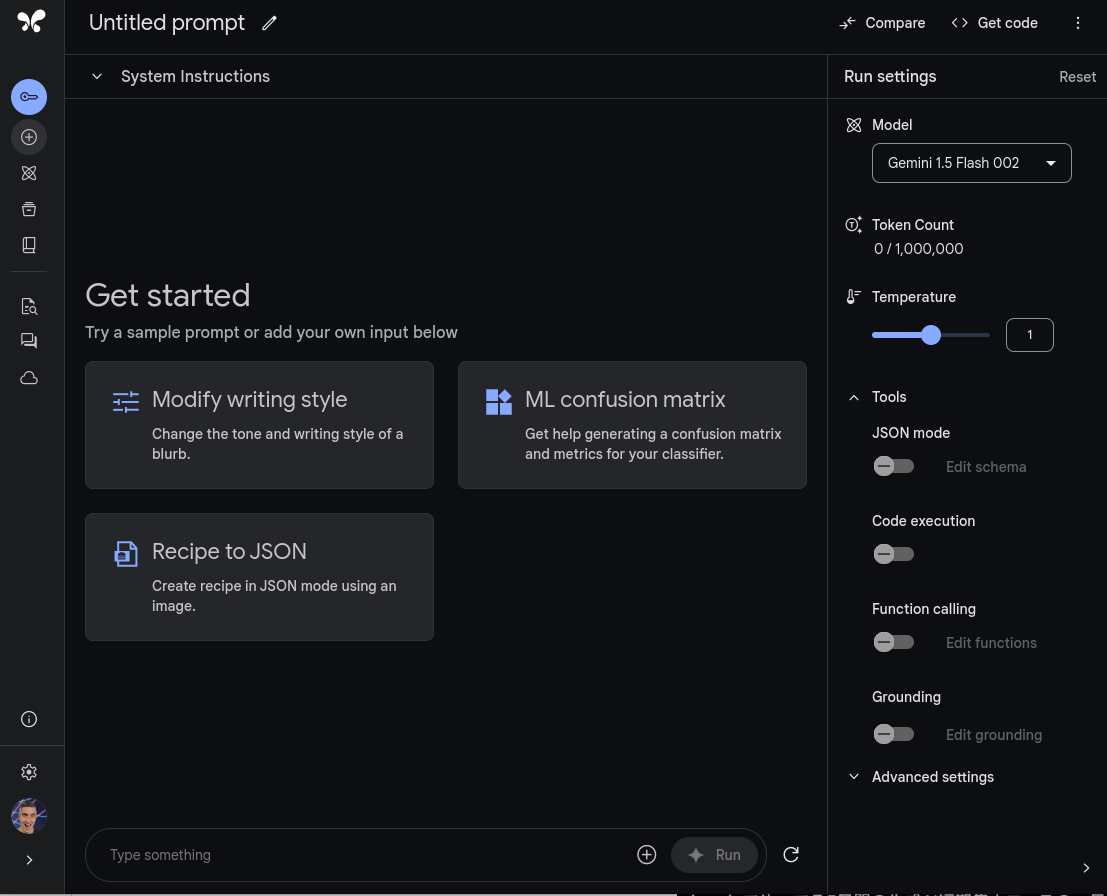
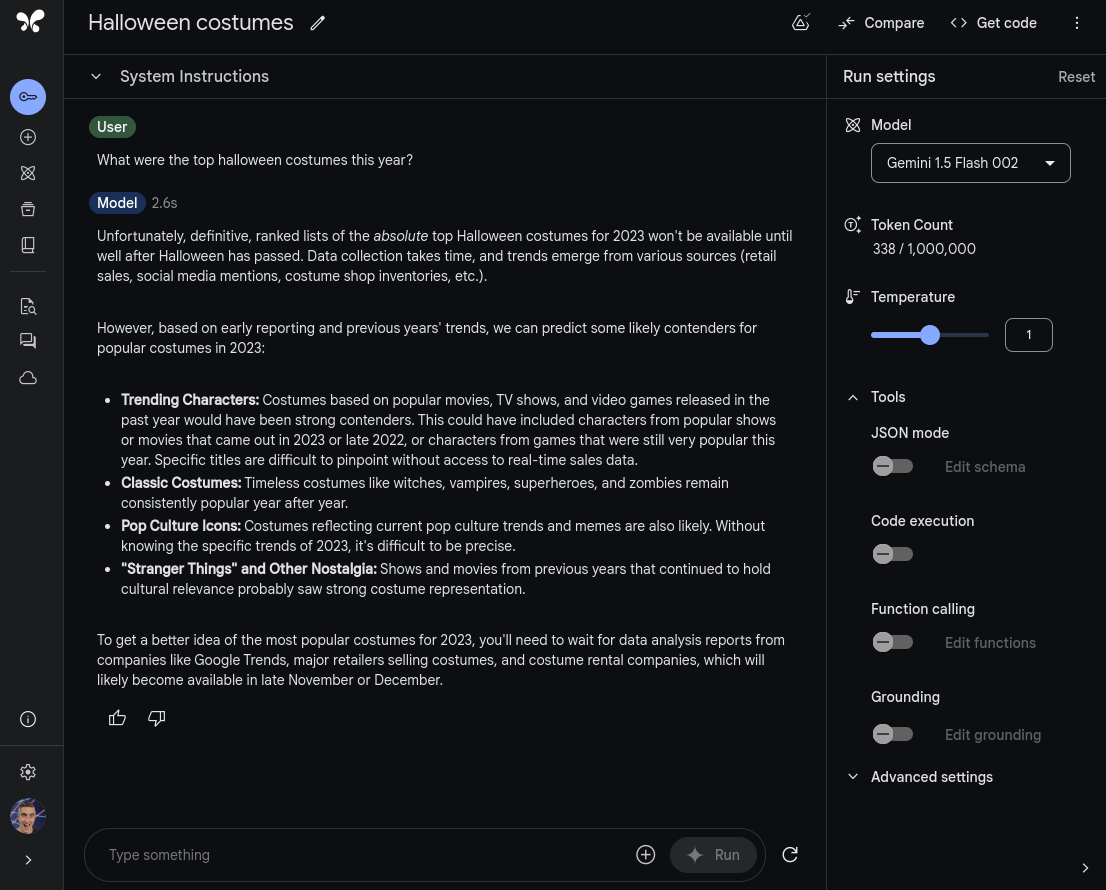
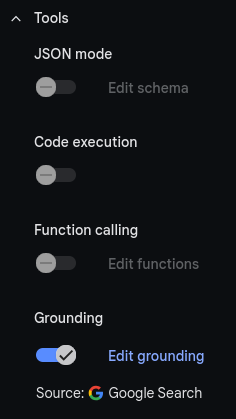
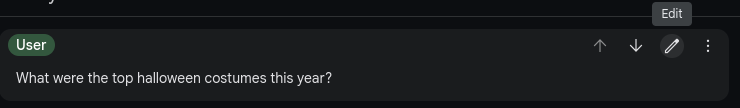
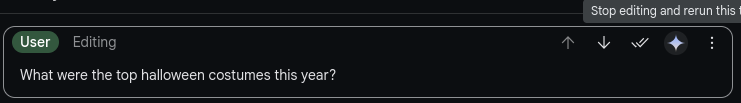
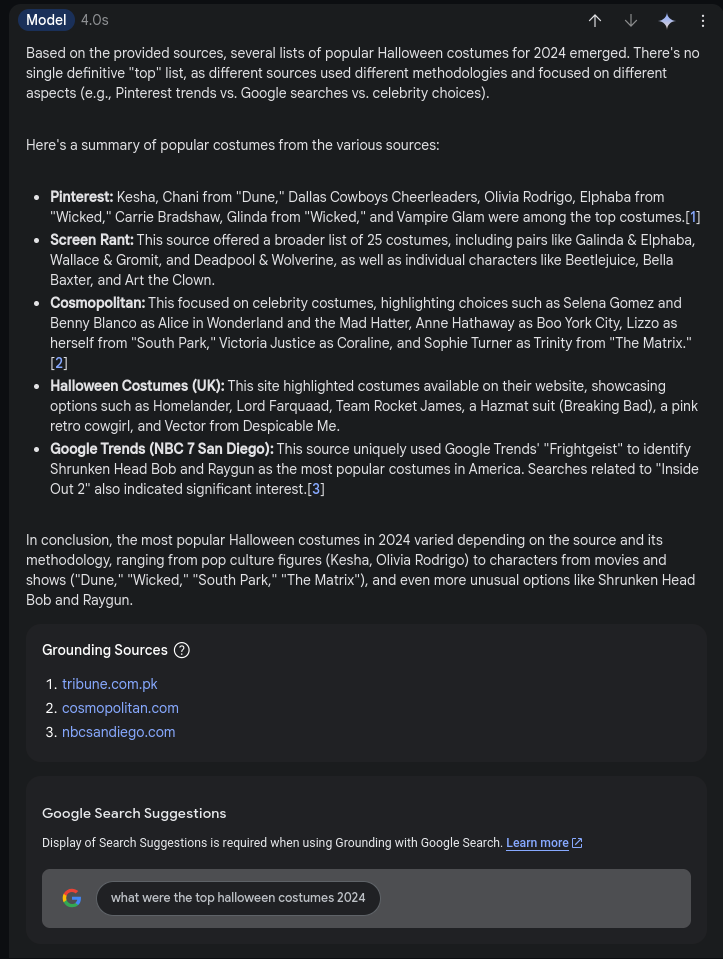

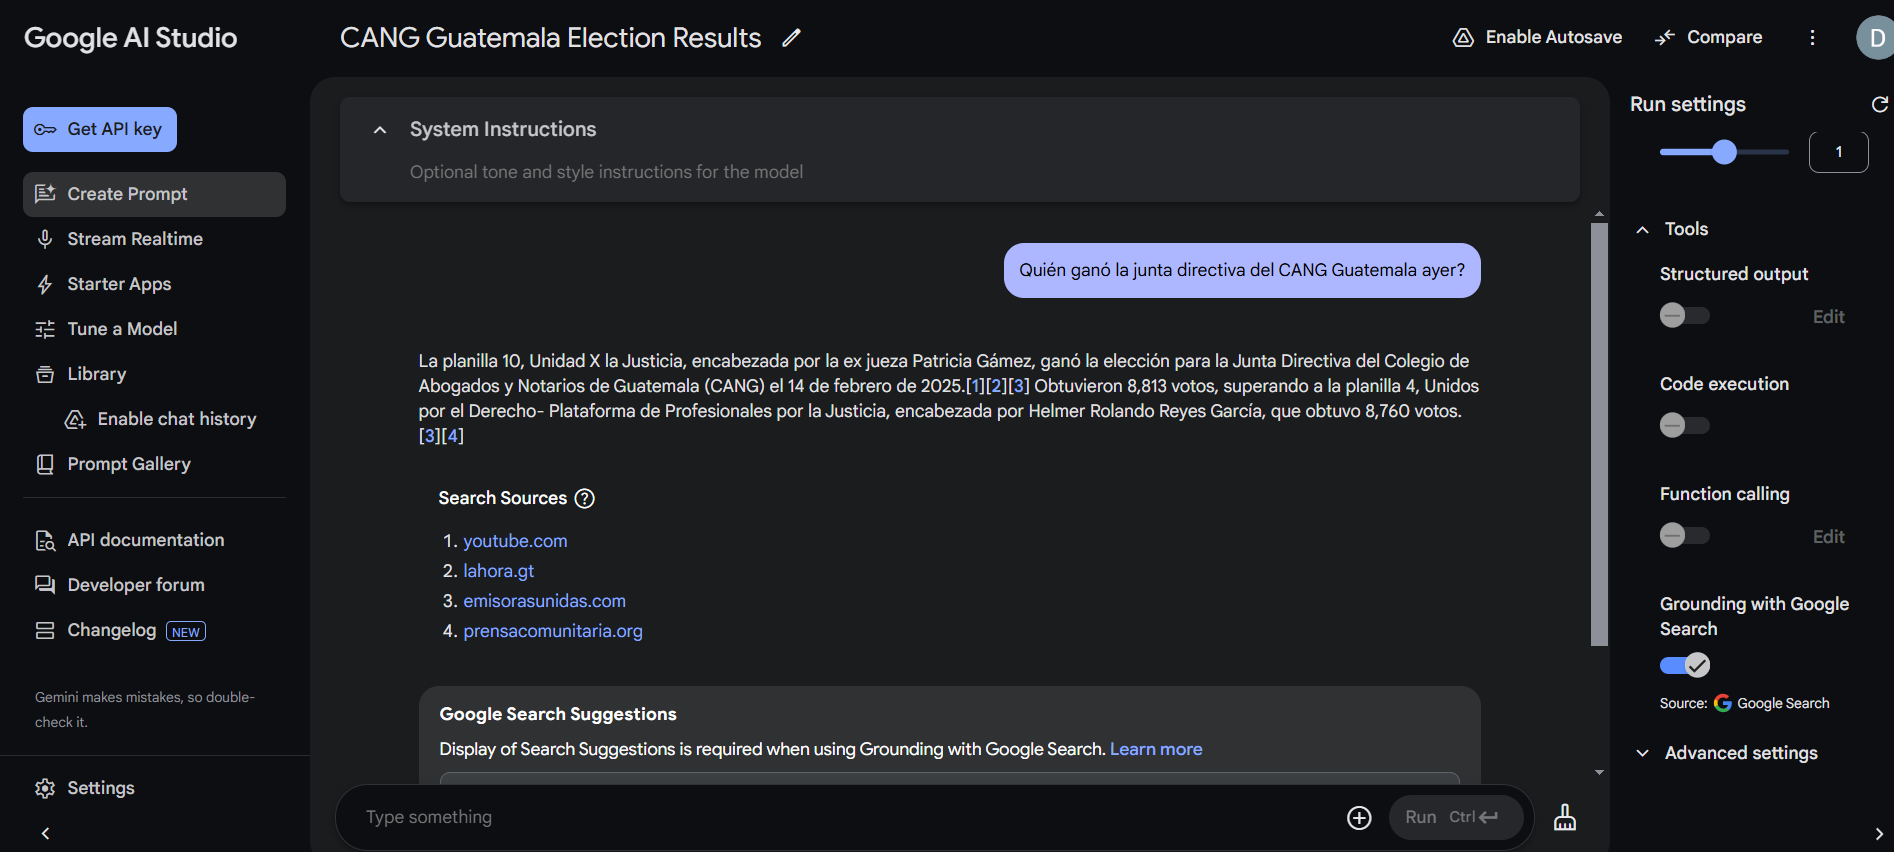

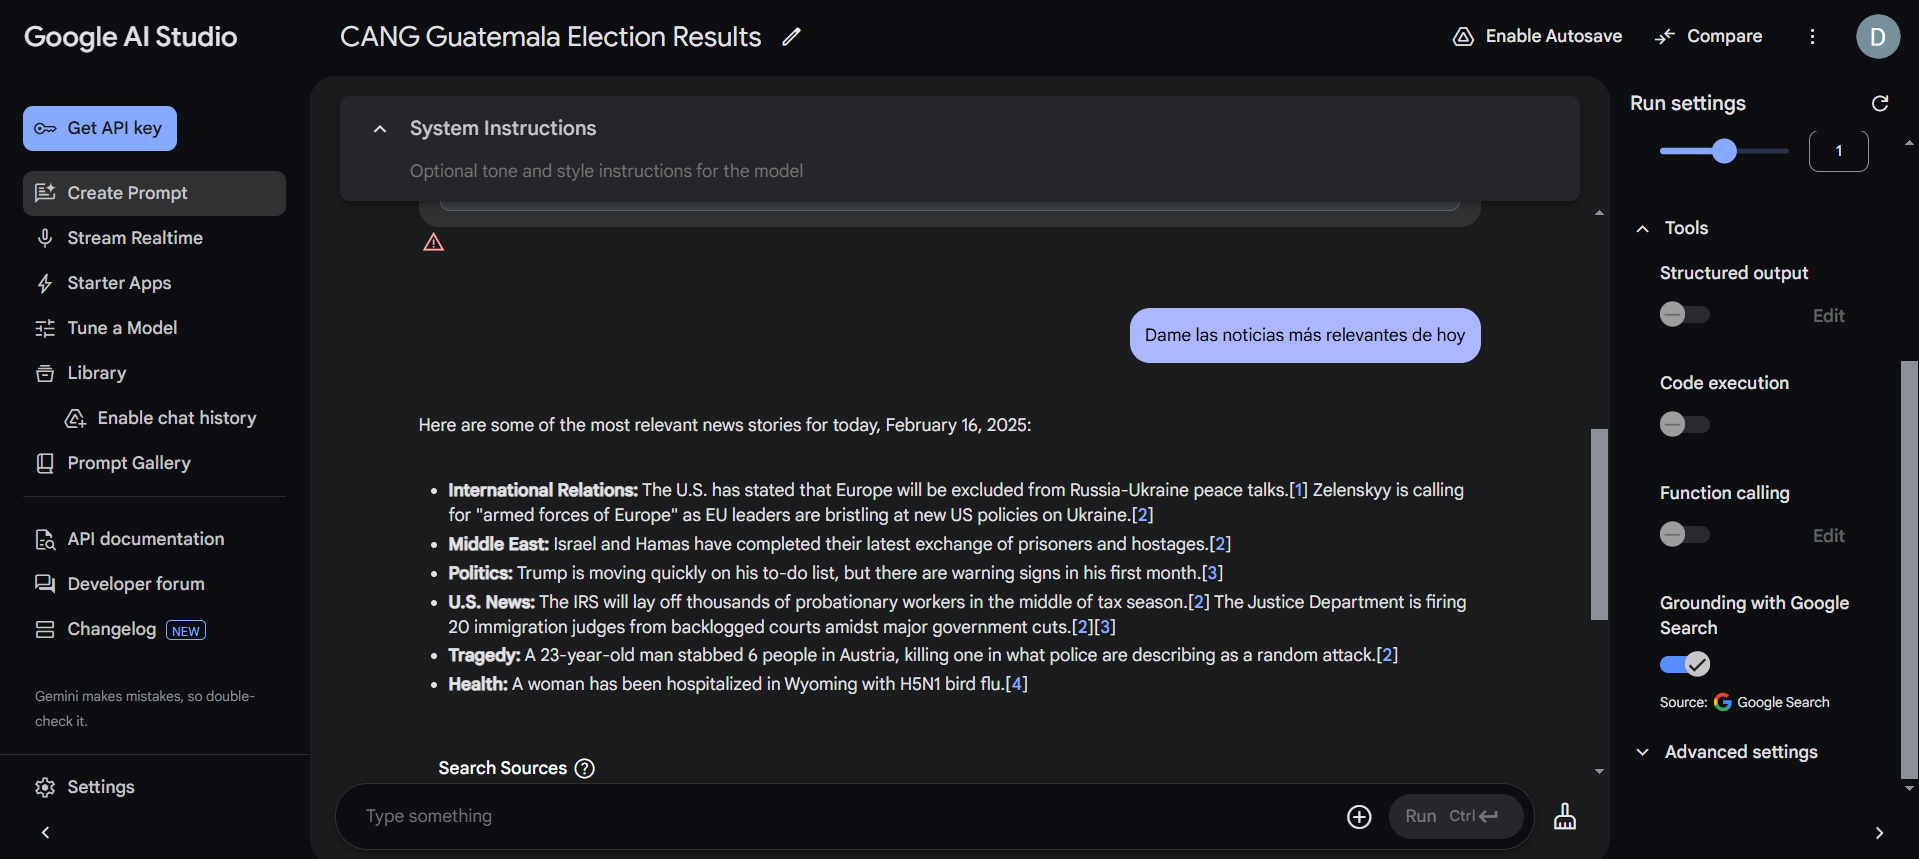

## API: Get set up

This section requires an API key with billing enabled. Start by installing and importing the Gemini API Python SDK.

In [ ]:
%pip install -q -U 'google-generativeai>=0.8.3'

You do not need to restart the kernel.

In [ ]:
import google.generativeai as genai
from IPython.display import Markdown, HTML, display

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [ ]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)
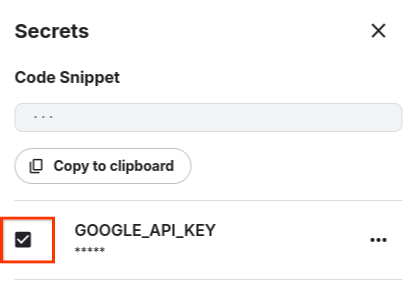

### Explore available models

Search grounding is a tool available in the `-002` series of models. Find a model that supports it through the [`models.list`](https://ai.google.dev/api/models#method:-models.list) endpoint. You can also find more information about different model capabilities on [the models page](https://ai.google.dev/gemini-api/docs/models/gemini).

In [ ]:
for model in genai.list_models():
    if "002" in model.name:
        print(model.name)

## Use search grounding

To enable search grounding, you specify it as a tool: `google_search_retrieval`. Like other tools, this can be supplied as a parameter to the model (to use on all chat turns or calls to `generate_content`), or it can be supplied per-turn to `chat.send_message`.


<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/app/prompts/1GTkO-gH4vd6G7LpBJ6Ay7U1OaJer7yDD"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [ ]:
# Ask for information without search grounding.
model = genai.GenerativeModel("gemini-1.5-flash-002")

response = model.generate_content("When and where is Taylor Swift's next concert?")

Markdown(response.text)

Now try with grounding enabled.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/14lDR0VjSni6BEUCZUBqj5PzTn3J194Th"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [ ]:
# And now re-run the same query with search grounding enabled.
model = genai.GenerativeModel(
    "gemini-1.5-flash-002",
    tools="google_search_retrieval")

response = model.generate_content("When and where is Taylor Swift's next concert?")
rc = response.candidates[0]

Markdown(rc.content.parts[0].text)

If you receive a `429 Resource has been exhausted` error, you are likely using a free tier API key. You can choose to enable billing (but this will incur charges), or you can try the queries in Google AI Studio by following the `Open in AI Studio` links above.

### Response metadata

When search grounding is used, the model returns extra metadata that includes links to search suggestions, supporting documents and information on how the supporting documents were used.

Each "grounding chunk" represents information retrieved from Google Search that was used in the grounded generation request. Following the URI will take you to the source.

In [ ]:
chunks = rc.grounding_metadata.grounding_chunks
for chunk in chunks:
    print(chunk)

As part of the response, there is a standalone styled HTML content block that you use to link back to relevant search suggestions related to the generation.

In [ ]:
HTML(rc.grounding_metadata.search_entry_point.rendered_content)

The `grounding_supports` in the metadata provide a way for you to correlate the grounding chunks used to the generated output text.

In [ ]:
supports = rc.grounding_metadata.grounding_supports
for support in supports:
    print(support)

These supports can be used to highlight text in the response, or build tables of footnotes.

In [ ]:
import io

markdown_buffer = io.StringIO()

# Print the text with footnote markers.
markdown_buffer.write("Supported text:\n\n")
for support in supports:
    markdown_buffer.write(" * ")
    markdown_buffer.write(
        response.text[support.segment.start_index : support.segment.end_index]
    )

    for i in support.grounding_chunk_indices:
        chunk = chunks[i].web
        markdown_buffer.write(f"<sup>[{i+1}]</sup>")

    markdown_buffer.write("\n\n")


# And print the footnotes.
markdown_buffer.write("Citations:\n\n")
for i, chunk in enumerate(chunks, start=1):
    markdown_buffer.write(f"* {i}: [{chunk.web.title}]({chunk.web.uri})\n")


Markdown(markdown_buffer.getvalue())

### Dynamic grounding

In a context where you may not know in advance whether to enable search grounding or not, you can provide the model with a threshold over which it will use search grounding. This is helpful in conversational contexts, where not every turn of conversation requires search data to support a response.

If you know whether to enable Search for any given chat turn, you can provide the tool explicitly.


<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1VBx_R16kNWa8g7lpLxQPx_08sFtd7tcd"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [ ]:
nosearch_model = genai.GenerativeModel("gemini-1.5-flash-002")
chat = nosearch_model.start_chat()

# No search grounding.
r = chat.send_message("Hello friendly chatbot!")

# Enable search for just this turn.
r = chat.send_message(
    "Who took home the 2023 cricket world cup?", tools="google_search_retrieval"
)

Markdown(r.text)

In [ ]:
HTML(r.candidates[0].grounding_metadata.search_entry_point.rendered_content)

Or you can let the Gemini API calculate a likelihood that the response needs search backing, and define the threshold to use.

In [ ]:
# The dynamic retrieval score is a probability, so the threshold
# must also be bound by [0, 1].
search_config = {
    "dynamic_retrieval_config": {"mode": "MODE_DYNAMIC", "dynamic_threshold": 0.5}
}

maybe_search_model = genai.GenerativeModel(
    "gemini-1.5-flash-002", tools={"google_search_retrieval": search_config}
)

chat = maybe_search_model.start_chat()

r = chat.send_message("Hello friendly chatbot!")
rc = r.candidates[0]
score = rc.grounding_metadata.retrieval_metadata.google_search_dynamic_retrieval_score
print(f"First turn: {score=}")

r = chat.send_message("Who took home the 2023 cricket world cup?")
rc = r.candidates[0]
score = rc.grounding_metadata.retrieval_metadata.google_search_dynamic_retrieval_score
print(f"Second turn: {score=}")
print()

display(Markdown(r.text))

In [ ]:
HTML(rc.grounding_metadata.search_entry_point.rendered_content)

## Further reading

When using search grounding, there are some specific requirements that you must follow, including when and how to show search suggestions, and how to use the grounding links.  Be sure to read and follow the details in the [search grounding capability guide](https://ai.google.dev/gemini-api/docs/grounding) and the [search suggestions guide](https://ai.google.dev/gemini-api/docs/grounding/search-suggestions).